
# Notebook 2

## Building a simple Multi-Fidelity Deep Gaussian Process

This notebook builds and trains a simple Multi-Fidelity Deep Gaussian Process (MFDGP) using the data presented in Noteboook 1.

### What is a Multi-Fidelity Deep Gaussian Process?

We start with a Gaussian Process or GP. This is a probabilistic regression method with optimises over functions rather than parameter of a specified function. The GP outputs a distribution of all the function that fit the data. We call this distribution the 'posterior' distribution.

For Deep GPs, the output of one GP is used as the input to the next and so forth, as shown in Figure 1.

Multi-Fidelity Deep GPs (MDFGPs) attribute a dataset of a given fidelity to each GP level. Fidelity can be defined as a combination of precision and accuracy. The first layer of the model corresponds to the lowest fidelity level whereas the highest fidelity is considered as the 'truth'. In this way, multiple datasets can effiently be combined together.

<p style="text-align:center;"/> <img src="images/MFDGP_diagram.png" alt="diagram" width="400"/>

Figure 1: Diagram of MFDGP model setup. The 'x' correspond to the datasets of different fidelities, 'f' to the corresponding GPs and 'y' to the GP ouputs.

### Why use MFDGP?
* Continuous predictions over time and space,
* Quantification of the likelihood of extreme events,
* High accuracy,
* Robust epsitimologic uncertainty.


## Experiment
In this experiment, we create a model with two fidelity levels corresponding to ERA5 climate reanalysis (low-fidelity, model simulation) and precipitation gauge data (high fidelity, in-situ observations). For a more detailed discussion of this method and how it is used in the project please refer to the 1st Year report. We use the [GPy](https://github.com/SheffieldML/GPy) and emukit (https://github.com/EmuKit/emukit) modules to achieve this.


### 1. Import libraries


In [51]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score

import GPy 

import emukit
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel

# custom modules
from load import era5, beas_sutlej_gauges

### 2. Load data

In [52]:
# Choose a station and download low and high-fidelity data 
station = 'Sainj'
hf_ds =  beas_sutlej_gauges.gauge_download(station, minyear=1980, maxyear=2011)
lf_ds =  era5.gauge_download(station, minyear=1980, maxyear=2011)

_Data/ERA5/combi_data_indus_10-2021.csv


In [53]:
# Remove NaN
hf_ds =  hf_ds.dropna(dim='time')
lf_ds =  lf_ds.dropna(dim='time')

In [54]:
# Split data into training and validation sets

# high-fidelity data needs to be smaller in length then low fidelity data
x_train_l = lf_ds.time[:330].values.reshape(-1,1)
x_train_h = hf_ds.time[:240].values.reshape(-1,1)

y_train_l = lf_ds.tp[:330].values.reshape(-1, 1)
y_train_h = hf_ds.tp[:240].values.reshape(-1,1)

x_val = hf_ds.time[240:330].values.reshape(-1,1) 
y_val = hf_ds.tp[240:330].values.reshape(-1,1)

In [55]:
# Format data with additional column for fidelity level
X_train, Y_train = convert_xy_lists_to_arrays([x_train_l, x_train_h], [y_train_l, y_train_h])

### 3. Create and train model

In [56]:
# Create model instance
kernels = [GPy.kern.RBF(1), GPy.kern.RBF(1)]
lin_mf_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
lin_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_mf_kernel, n_fidelities=2)
lin_mf_model.mixed_noise.Gaussian_noise.fix(0) # fix noise to 0 
lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)
lin_mf_model.optimize_restarts(num_restarts=5)

array([0])

In [59]:
# Train model
lin_mf_model.optimize_restarts(num_restarts=5)

 /opt/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /opt/anaconda3/lib/python3.8/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /opt/anaconda3/lib/python3.8/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/5, f = 637637081.8821723
Optimization restart 2/5, f = 1617.7865521611864
Optimization restart 3/5, f = 1609.0924820715727
Optimization restart 4/5, f = 380187844.86424875
Optimization restart 5/5, f = 1609.0924820097225


### 4. Plot model output
 

In [60]:
# Create plot input data
x_plot = np.linspace(1995.80, 2004.35, 600)[:, np.newaxis]
X_plot = convert_x_list_to_array([x_plot, x_plot])
X_plot_low = X_plot[:600]
X_plot_high = X_plot[600:]

In [73]:
hf_samples.T.shape

(10, 1, 600)

In [63]:
# Wrap model and alculate model posterior mean and standard deviation
wrp_model = GPyMultiOutputWrapper(gpy_lin_mf_model, 2, n_optimization_restarts=5)

hf_mean_lin_mf_model, hf_var_lin_mf_model = wrp_model.predict(X_plot_high)
hf_std_lin_mf_model = np.sqrt(hf_var_lin_mf_model)
lf_mean_lin_mf_model, lf_var_lin_mf_model = wrp_model.predict(X_plot_low)
lf_std_lin_mf_model = np.sqrt(lf_var_lin_mf_model)

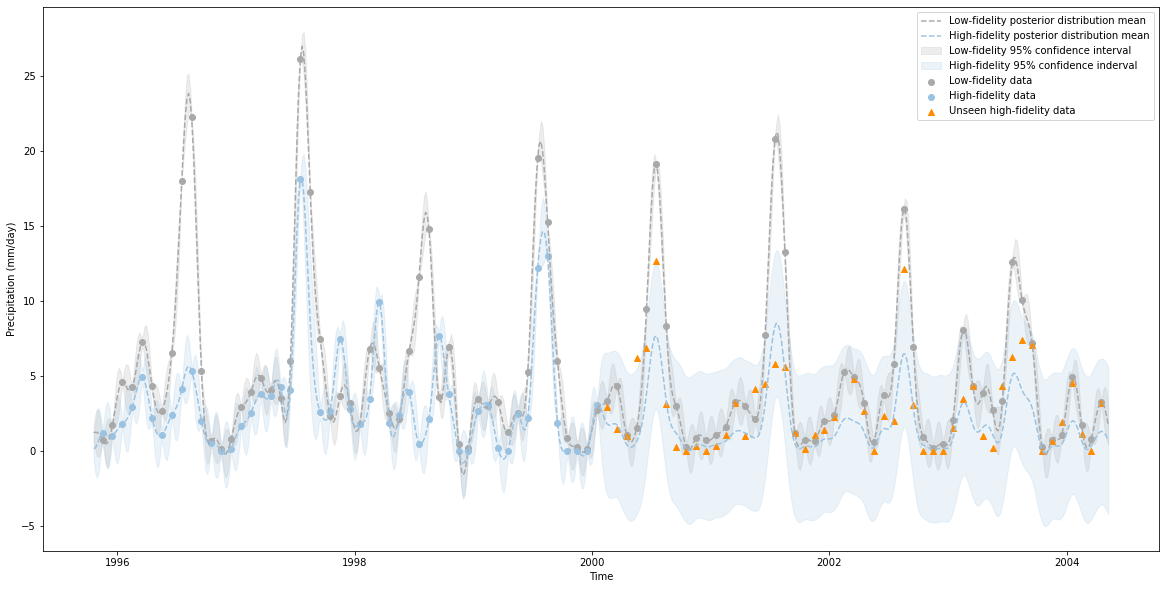

In [47]:
plt.figure(figsize=(20,10))

oned_x_plot = x_plot.flatten()
oned_lf_mean_lin_mf_model =  lf_mean_lin_mf_model.flatten()
oned_lf_std_lin_mf_model =  lf_std_lin_mf_model.flatten()
oned_hf_mean_lin_mf_model =  hf_mean_lin_mf_model.flatten()
oned_hf_std_lin_mf_model =  hf_std_lin_mf_model.flatten()

plt.fill_between(oned_x_plot, oned_lf_mean_lin_mf_model - 1.96 * oned_lf_std_lin_mf_model, oned_lf_mean_lin_mf_model + 1.96 * oned_lf_std_lin_mf_model, color='darkgray', alpha=0.2, label='Low-fidelity 95% confidence interval')
plt.fill_between(oned_x_plot, oned_hf_mean_lin_mf_model - 1.96 * oned_hf_std_lin_mf_model, oned_hf_mean_lin_mf_model + 1.96 * oned_hf_std_lin_mf_model, color='#9BC3E1', alpha=0.2, label='High-fidelity 95% confidence inderval')

plt.plot(x_plot,  lf_mean_lin_mf_model, linestyle='--', color='darkgray', label='Low-fidelity posterior distribution mean')
plt.plot(x_plot,  hf_mean_lin_mf_model, linestyle='--', color='#9BC3E1', label='High-fidelity posterior distribution mean')

plt.scatter(x_train_l[190:292], y_train_l[190:292], c='darkgray', label='Low-fidelity data')
plt.scatter(x_train_h[190:],  y_train_h[190:], c='#9BC3E1', label='High-fidelity data')
plt.scatter(x_val[:50],  y_val[:50], c='darkorange', marker= '^', label= 'Unseen high-fidelity data')

plt.xlabel('Time')
plt.ylabel('Precipitation (mm/day)')
plt.legend()
plt.show()

We can also look at the samples from the posterior distribution. 

 /opt/anaconda3/lib/python3.8/site-packages/GPy/core/gp.py:614: RuntimeWarning:covariance is not positive-semidefinite.


Text(0.5, 1.0, 'Posterior distribution samples')

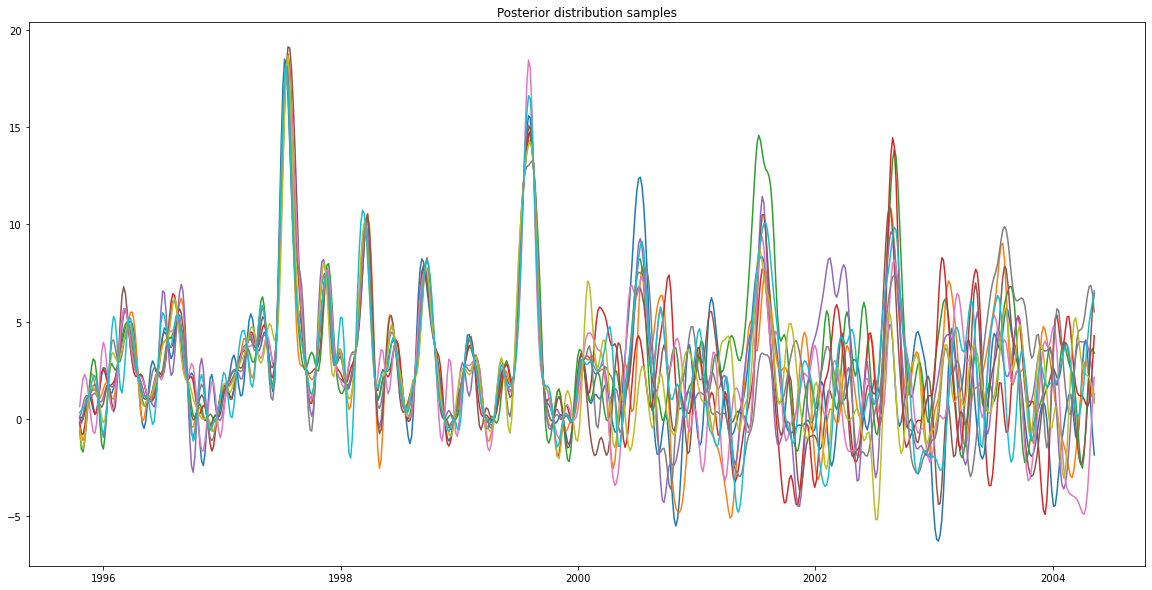

In [82]:
# Generate and plot model samples 
hf_samples = lin_mf_model.posterior_samples_f(X_plot_high, size=10)

plt.figure(figsize=(20,10))
for f in hf_samples.T:
    oned_x_plot = x_plot.flatten()
    oned_f = f.flatten()
    plt.plot(oned_x_plot, oned_f)
plt.title('Posterior distribution samples')